In [69]:
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

import pandas as pd

##
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle # Read and Save model - Serialization
from datetime import datetime

# custom functions
import sys
sys.path.append("/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals")
from myscripts import util
from myscripts import plot

In [70]:
## Read Datas

train_store_file = '../data/clean_train_store.csv'

In [71]:
train_store_df = pd.read_csv(train_store_file, parse_dates = True, low_memory = False)

### Preprocessing

In [72]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   Year                       1017209 non-null  int64  
 10  Month                      1017209 non-null  int64  
 11  Day                        1017209 non-null  int64  
 12  WeekOfYear                 1017209 non-null  int64  
 13  StoreType   

In [102]:
# ### columns to use
# columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
#        'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']


## Lable Date and StateHoiday Train
columns = ['Sales','Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

sample_size = 1000
sampled_df = train_store_df[columns].sample(sample_size)


## Separet Test and train files
train_x = sampled_df[feature_columns]
train_y = sampled_df[['Sales']]
train_x.head()


,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,WeekOfYear,Month,Year,StoreType,Assortment,CompetitionDistance,Promo2
506133,556,1,0,0,0,25,22,5,2015,d,c,1140.0,0
504188,553,4,1,0,0,27,26,6,2013,c,a,3040.0,1
103723,114,4,1,1,0,19,51,12,2013,c,a,4510.0,1
430790,472,2,1,0,0,6,32,8,2013,c,c,5030.0,0
360918,396,7,0,0,0,7,49,12,2014,a,c,23130.0,0


In [103]:
### Label encoding
lb = LabelEncoder()
train_x['StoreType'] = lb.fit_transform(train_x['StoreType'])
train_x['Assortment'] = lb.fit_transform(train_x['Assortment'])

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 506133 to 705361
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1000 non-null   int64  
 1   DayOfWeek            1000 non-null   int64  
 2   Open                 1000 non-null   int64  
 3   Promo                1000 non-null   int64  
 4   SchoolHoliday        1000 non-null   int64  
 5   Day                  1000 non-null   int64  
 6   WeekOfYear           1000 non-null   int64  
 7   Month                1000 non-null   int64  
 8   Year                 1000 non-null   int64  
 9   StoreType            1000 non-null   int64  
 10  Assortment           1000 non-null   int64  
 11  CompetitionDistance  1000 non-null   float64
 12  Promo2               1000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 109.4 KB


In [104]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# X = x_scaler.fit_transform(train_x)
X = train_x
Y = y_scaler.fit_transform(train_y)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [106]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=25, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, random_state=0)

In [107]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 59.67%


In [108]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
            
    print()

## Running this code will create multiple mflow models 
## Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)

### Building models with sklearn pipelines

In [109]:
## Prepare the training and test features
x = train_x
y = train_y

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [110]:
### Pipe Lines ###

rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rfr_regretion', RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0))
])

lr = Pipeline(steps=[
    ('scaler2', MinMaxScaler()),
    ('lr_regretion', LinearRegression())
])

dt = Pipeline(steps=[
    ('scaler3', MinMaxScaler()),
    ('dt_regretion', DecisionTreeRegressor(random_state = 0)  )
])


In [111]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler3', MinMaxScaler()),
                ('dt_regretion', DecisionTreeRegressor(random_state=0))])

In [112]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"Prediction Score of the RandomForestRegretion is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegretion is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTree is {round(dt_score * 100, 2)}%")

# print(rfr_score)

Prediction Score of the RandomForestRegretion is 65.42%
Prediction Score of the LinearRegretion is 62.42%
Prediction Score of the DecisionTree is 35.81%


### Choose a loss function

In [113]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse, rft_mae, _ = util.eval_metrics(y_test, rfr_prediction)
lr_rmse, lr_mae, _ = util.eval_metrics(y_test, lr_prediction)
dt_rmse, dt_mae, _ = util.eval_metrics(y_test, dt_prediction)


# print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")
print(f"RandomForest Mean Square Loss : {rfr_rmse}")
print(f"Linear Mean Square Loss : {lr_rmse}")
print(f"DecisionTree Mean Square Loss : {dt_rmse }%")

RandomForest Mean Square Loss : 2093.132399328146
Linear Mean Square Loss : 2181.9769522185516
DecisionTree Mean Square Loss : 2851.736600739977%


### Post Prediction analysis

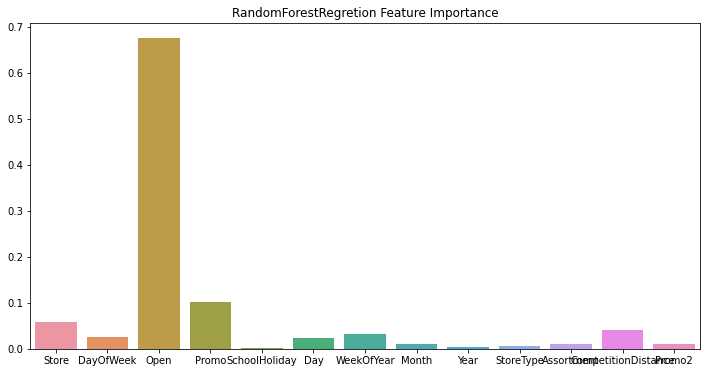

In [114]:

important_features = rfr[1].feature_importances_
plot.bar(feature_columns, important_features, 'RandomForestRegretion Feature Importance')

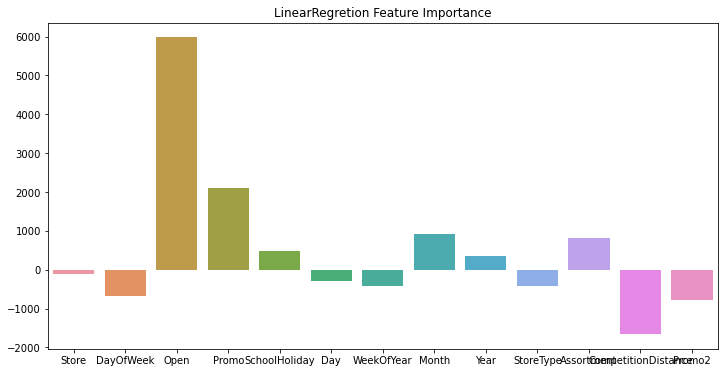

In [115]:
important_features = lr[1].coef_[0]
from matplotlib import pyplot as plt
plot.bar(feature_columns, list(important_features), "LinearRegretion Feature Importance")

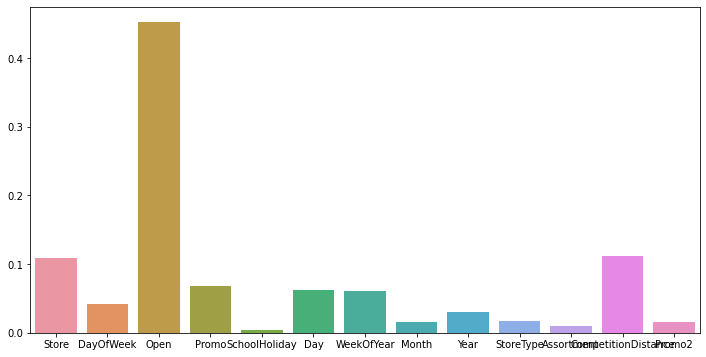

In [116]:
important_features = dt[1].feature_importances_
plot.bar(feature_columns, important_features)

### Serialize models

In [92]:
## use picke to dump mode
## decomment picke to save the model

reg_model_file_name = f'../models/reg-{datetime.now()}.pkl'
lr_model_file_name = f'../models/lt-{datetime.now()}.pkl'
dt_model_file_name = f'../models/dt-{datetime.now()}.pkl'

files = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

print(reg_model_file_name)


# for i in range(len(files)):
#         pickle.dump(models[i], open(files[i], 'wb'))

../models/reg-2021-07-30 12:04:14.474625.pkl


In [ ]:
### Add the mlflow here


In [93]:
dt_file = '../models/dt-2021-07-30 09:51:48.726269.pkl'
lr_file = '../models/lt-2021-07-30 12:04:14.474722.pkl'
model = pickle.load(open(lr_file, 'rb'))

In [94]:
score = model.score(X_test, y_test)
score

0.5447036122852738